# Dimensionality reduction

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

C:\Users\valen\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.12.1+cpu
Using device: cpu


## Loading data and model

In [2]:
mouse_id = 'Mouse24'
session_id = '131213'
phase = 'wake'
subset = 'nonhdc'

bin_size = 160  # ms

# data
single_spikes = False
dataset_hdc = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size,
                               single_spikes, path='../data/')

dataset_nonhdc = HDC.get_dataset(mouse_id, session_id, phase, 'nonhdc', bin_size, single_spikes, path='../data/')

In [3]:
bin_size = 160  # ms

model_dict_hdc = {
    'seed': 123,
    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
    'filt_mode': '',  # GLM couplings
    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
    'z_mode': '',  # latent covariates
    'hist_len': 0,
    'folds': 5,
    'delays': [0],
    'neurons': dataset_hdc['neurons'],
    'max_count': dataset_hdc['max_count'],
    'bin_size': dataset_hdc['bin_size'],
    'tbin': dataset_hdc['tbin'],
    'model_name': dataset_hdc['name'],
    'tensor_type': torch.float,
    'jitter': 1e-5,
}

model_dict_nonhdc = {
    'seed': 123,
    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
    'filt_mode': '',  # GLM couplings
    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
    'z_mode': '',  # latent covariates
    'hist_len': 0,
    'folds': 5,
    'delays': [0],
    'neurons': dataset_nonhdc['neurons'],
    'max_count': dataset_nonhdc['max_count'],
    'bin_size': dataset_nonhdc['bin_size'],
    'tbin': dataset_nonhdc['tbin'],
    'model_name': dataset_nonhdc['name'],
    'tensor_type': torch.float,
    'jitter': 1e-5,
}

checkpoint_dir = '../models/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

# model and train/test split based on which validation fold is given by cv_run
modelfit_hdc, training_results_hdc, fit_set_hdc, validation_set_hdc = lib.models.load_model(
    checkpoint_dir, model_dict_hdc, dataset_hdc, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev
)

modelfit_nonhdc, training_results_nonhdc, fit_set_nonhdc, validation_set_nonhdc = lib.models.load_model(
    checkpoint_dir, model_dict_nonhdc, dataset_nonhdc, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev
)

C:\Users\valen\UCM-interpret\scripts\HDC.py:165: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  kernel_tuples += [('SE', 'torus', torch.tensor(ang_ls))]


## Compute spike count distributions and tuning curves

In [5]:
rcov = dataset_hdc['covariates']

# check covariates are in the right order
covkeys = ''
for k in rcov.keys():
    covkeys += k + '-'
covkeys = covkeys[:-1]
assert covkeys == model_dict_hdc['x_mode']


In [7]:
def tuning_curve_1d(cov_name, use_neuron, modelfit, rcov, num_points=100, MC=30, batch_size=1000):
    lower_limit = np.min(rcov[cov_name])
    upper_limit = np.max(rcov[cov_name])
    sweep = torch.linspace(lower_limit, upper_limit, num_points)[None, :]

    rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
    with torch.no_grad():
        P_mc = lib.helper.marginalized_P(modelfit, sweep, [list(rcov.keys()).index(cov_name)], rcov_matrix, batch_size, use_neuron, MC)

    return P_mc, sweep

In [8]:
neurons = list(range(dataset_hdc['neurons']))

P_mc, sweep = tuning_curve_1d('hd', neurons, modelfit_hdc, rcov, batch_size=100)

0


C:\Users\valen\UCM-interpret\neuroprob\mappings\GP.py:47: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1755.)
  Lff = Kff.cholesky() # N, N_u, N_u
C:\Users\valen\UCM-interpret\neuroprob\mappings\GP.py:70: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced wit

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [9]:
P_mc_hdc = P_mc
print(P_mc_hdc.shape)

torch.Size([30, 5, 100, 15])


In [17]:
K = P_mc_hdc.shape[-1]
counts = torch.arange(K)
tbin = model_dict_hdc['tbin']

hd_mean = (counts[None, None, None, :] * P_mc_hdc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc_hdc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

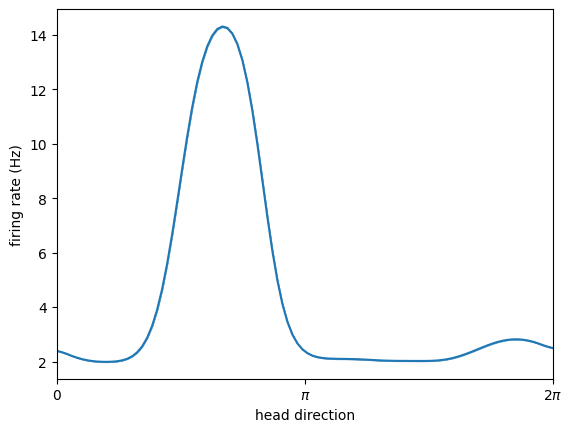

In [18]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 0  # select neuron to plot

x_sweep = sweep.numpy().flatten()

line, = ax.plot(x_sweep, mean[ne, :].numpy())
ax.fill_between(
    x_sweep, lower[ne, :].numpy(), upper[ne, :].numpy(),
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

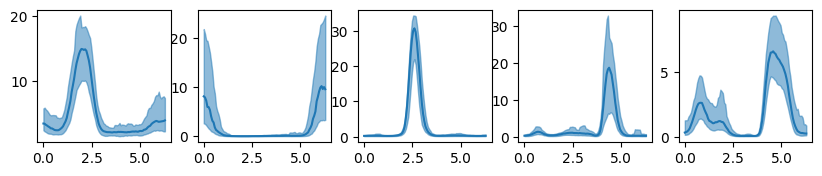

In [44]:
plt.figure(figsize=(10, 10))

for i in range(mean.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.plot(mean[i])
    plt.fill_between(
        hd_sweep.numpy(), lower[i, :].numpy(), upper[i, :].numpy(),
        color=line.get_color(), alpha=0.5
    )
plt.show()

In [33]:
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc_nonhdc, [0.05, 0.5, 0.95])

K = P_mc_nonhdc.shape[-1]
counts = torch.arange(K)
tbin = model_dict_nonhdc['tbin']

hd_mean = (counts[None, None, None, :] * P_mc_nonhdc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc_nonhdc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

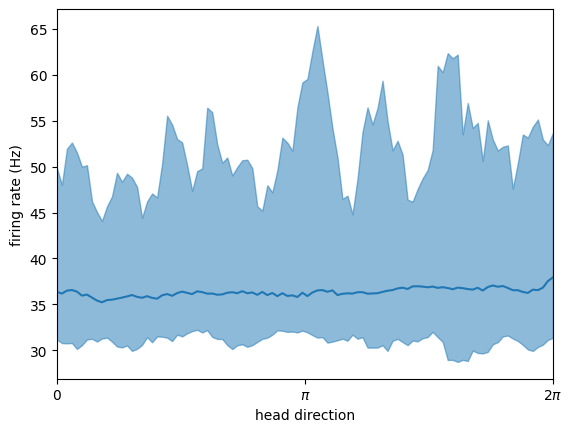

In [34]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 4  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(),
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

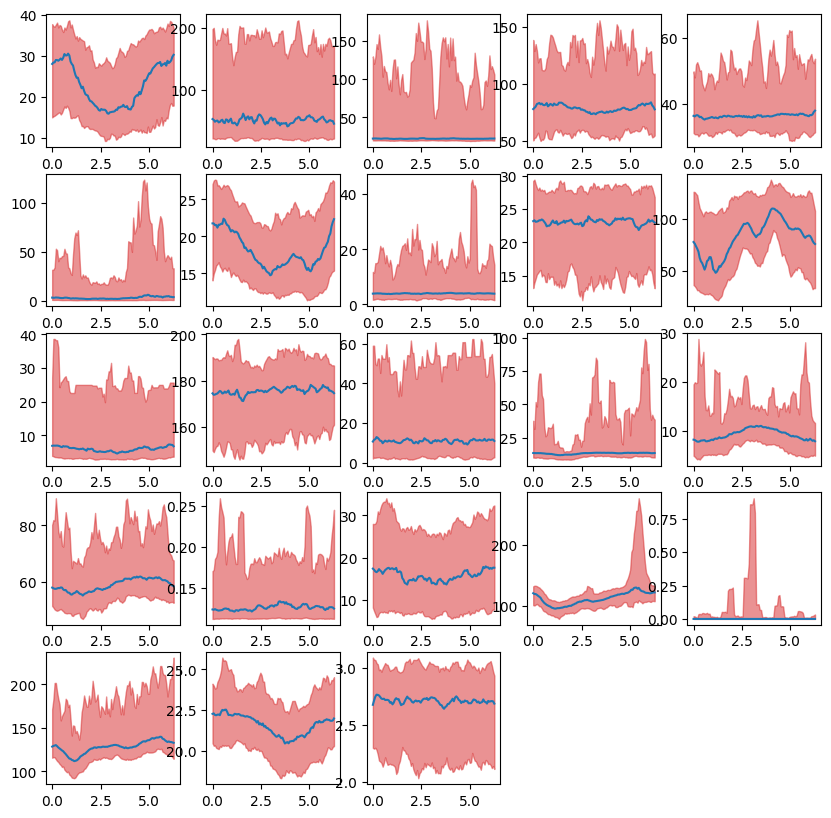

In [38]:
plt.figure(figsize=(10, 10))

for i in range(mean.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.plot(hd_sweep.numpy(), mean[i])
    plt.fill_between(
        hd_sweep.numpy(), lower[i, :].numpy(), upper[i, :].numpy(),
        color=line.get_color(), alpha=0.5
    )
plt.show()

## Tuning index computation

In [45]:
def tuning_index(x):
    return (np.max(x) - np.min(x)) / (np.max(x) + np.min(x))

In [ ]:
def tuning_curve(cov_name):

